In [5]:
import pandas as pd

url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv"
df = pd.read_csv(url)

df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-08-05T05:28:34.740Z,33.476500,-117.383667,8.790,1.25,ml,12.0,98.0,0.049960,0.27,...,2025-08-05T05:32:32.597Z,"17 km NW of Fallbrook, CA",earthquake,0.70,2.160,0.199,13.0,automatic,ci,ci
1,2025-08-05T05:22:23.700Z,33.674167,-116.781500,14.970,0.86,ml,30.0,43.0,0.070700,0.26,...,2025-08-05T05:25:50.691Z,"9 km SW of Idyllwild, CA",earthquake,0.36,0.730,0.178,10.0,automatic,ci,ci
2,2025-08-05T05:19:50.200Z,33.264500,-116.423833,4.800,0.90,ml,55.0,26.0,0.006699,0.21,...,2025-08-05T05:23:13.676Z,"5 km WNW of Borrego Springs, CA",earthquake,0.16,0.350,0.163,25.0,automatic,ci,ci
3,2025-08-05T05:14:22.180Z,35.996167,-117.696667,3.240,0.69,ml,20.0,63.0,0.061070,0.14,...,2025-08-05T05:17:50.126Z,"20 km ENE of Little Lake, CA",earthquake,0.19,0.570,0.120,12.0,automatic,ci,ci
4,2025-08-05T05:06:44.777Z,28.028500,59.084500,56.726,5.40,mb,104.0,48.0,4.011000,1.28,...,2025-08-05T05:34:02.467Z,"139 km SSE of Bam, Iran",earthquake,8.48,1.555,0.039,225.0,reviewed,us,us


In [6]:
df = df[['time', 'latitude', 'longitude', 'depth', 'mag', 'place']]
df = df.dropna()

df['time'] = pd.to_datetime(df['time'])

In [7]:
def classify_risk(mag):
    if mag >= 6.0:
        return 'high'
    elif mag >= 4.0:
        return 'medium'
    else:
        return 'low'

df['risk_level'] = df['mag'].apply(classify_risk)
df['risk_level_encoded'] = df['risk_level'].map({'low': 0, 'medium': 1, 'high': 2})

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

features = ['mag', 'depth', 'latitude', 'longitude']
target = 'risk_level_encoded'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9995888157894737
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2135
           1       1.00      1.00      1.00       292
           2       1.00      1.00      1.00         5

    accuracy                           1.00      2432
   macro avg       1.00      1.00      1.00      2432
weighted avg       1.00      1.00      1.00      2432



In [9]:
!pip install folium

In [10]:
import folium

map_center = [df['latitude'].mean(), df['longitude'].mean()]
earthquake_map = folium.Map(location=map_center, zoom_start=2)

def get_color(risk):
    if risk == 'high':
        return 'red'
    elif risk == 'medium':
        return 'orange'
    else:
        return 'green'

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=get_color(row['risk_level']),
        fill=True,
        fill_color=get_color(row['risk_level']),
        popup=f"Magnitude: {row['mag']}, Risk: {row['risk_level']}"
    ).add_to(earthquake_map)

earthquake_map

Output hidden; open in https://colab.research.google.com to view.

/tmp/ipython-input-3449248979.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='risk_level', palette='Set2')


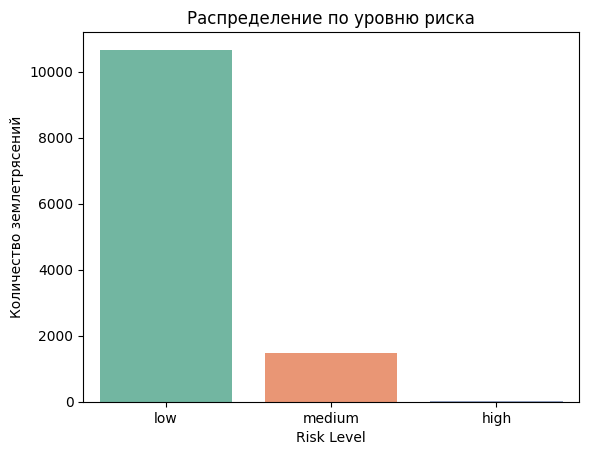

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='risk_level', palette='Set2')
plt.title('Распределение по уровню риска')
plt.xlabel('Risk Level')
plt.ylabel('Количество землетрясений')
plt.show()

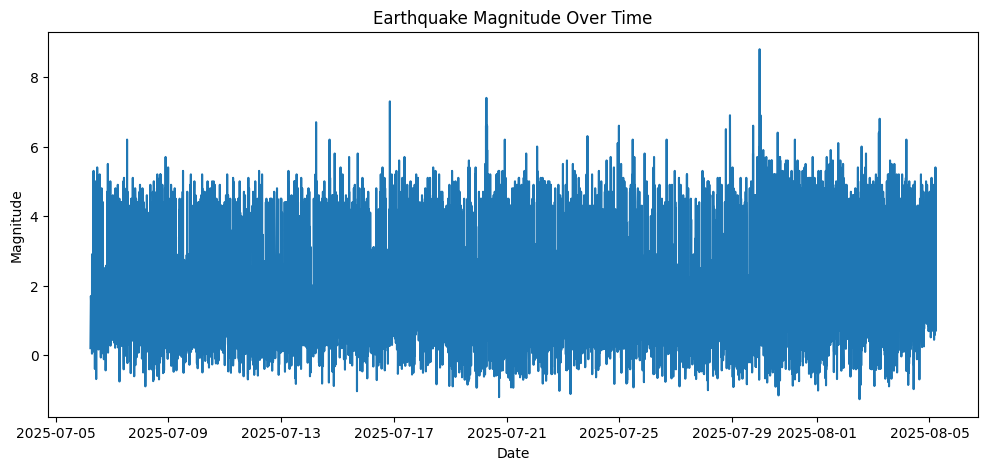

In [13]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.sort_values('time'), x='time', y='mag')
plt.title('Earthquake Magnitude Over Time')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9995888157894737
